In [13]:
from ipywidgets import *
from IPython.display import clear_output, display, Javascript, HTML, Image, Markdown
from tkinter import Tk, filedialog
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import timedelta
from pathlib import Path
from shapely.geometry import LineString
from scipy.spatial import distance
from base64 import b64decode
from statistics import mean

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import warnings
import datetime
import math
import io
import os

def button_create(description,style):
    button_icon = widgets.Button(description=description, button_style=style)
    button_output = widgets.Output()
    return(button_icon,button_output)

def dropdown_create(options,description,layout,style):
    dropdown = widgets.Dropdown(options=options, description=description,layout=layout,style=style)
    return(dropdown)
    
def mini_maxi(df,col):
    mini=df[col].min()
    maxi=df[col].max()
    mini_d=df.index.min()
    maxi_d=df.index.max()
    return (mini, maxi, mini_d, maxi_d)

def min_max_in_tuples(tuple1,tuple2):
    mini=min(tuple1[0],tuple2[0])
    maxi=max(tuple1[1],tuple2[1])
    mini_d=min(tuple1[2],tuple2[2])
    maxi_d=max(tuple1[3],tuple2[3])
    return (mini, maxi, mini_d, maxi_d)

def add_to_config(widget_key,list_config):
    lst=list(widget_key)
    list_config.append(" ".join(lst))
    return list_config

In [14]:
button_code = button_create("Upload files", "success")
button_code_plots = button_create("Show plots", "success")
button_settlement = button_create("Settlement plots","info")
button_piezo = button_create("Piezo plots","info")
button_c_and_t = button_create("Crest and Toe plots","info")
button_porewater_pressure = button_create("Excess PWP & FoS","info")
button_pair_s_and_t = button_create("Stability Plot","info")
button_asaoka = button_create("Asaoka","info")
button_guo = button_create("Guo & Chu","info")

format_data = widgets.ToggleButtons(options=['.csv', '.xlsx'],button_style='info')

upload_comments = widgets.FileUpload(accept='',multiple=True)
upload_settlement = widgets.FileUpload(accept='',multiple=True)
upload_load = widgets.FileUpload(accept='',multiple=False)
upload_piezo = widgets.FileUpload(accept='',multiple=True)
upload_crest = widgets.FileUpload(accept='',multiple=True)
upload_toe = widgets.FileUpload(accept='',multiple=True)

style = {'description_width': '130px'}
u_water = widgets.BoundedFloatText(value=9.81,description='Unit weight of water',style=style)
wl = widgets.BoundedFloatText(value=0,description='Water level (mbgl)',min=-999,style=style)
u_emb = widgets.BoundedFloatText(value=0, description='Unit weight of fill',style=style)
u_soil = widgets.BoundedFloatText(value=0, description='Unit weight of soil',style=style)
su = widgets.BoundedFloatText(value=0, description='Ratio of su to s\'',style=style)

In [15]:
def upload_file(arg):
    with button_upload[1]:
        print("\033[1mSelect files format:\n\033[0m")
        
        format_data.add_class("left-spacing-class")
        display(format_data)
        upload_comments.add_class("left-spacing-class")
        hbox1 = HBox([upload_settlement, upload_load, upload_piezo,upload_crest, upload_toe])
        hbox1.add_class("left-spacing-class")
        display(HTML("<style>.left-spacing-class {margin-left: 95px;}</style>"))

        print("\033[1mImport files with upload buttons:\n\033[0m")
        print("                 Annotation")
        display(upload_comments)
        print("                 Settlement         Construction           Piezo               Crest               Toe")
        display(hbox1)

        button_code[0].add_class("left-spacing-class")
        display(button_code[0],button_code[1])


In [16]:
def on_button_clicked_code(arg):
    with button_code[1]:
        on_button_clicked_code.config_list = []

        #create a dataframe for comments
        try:
            comments = upload_comments.value.keys()
            on_button_clicked_code.config_list = add_to_config(comments,on_button_clicked_code.config_list)
            data=[key for key in comments][0]
            data=upload_comments.value[data]['content']
            if format_data.value == ".csv":
                df_comments=pd.read_csv(io.BytesIO(data)).sort_index()
            else:
                df_comments=pd.read_excel(io.BytesIO(data)).sort_index()
        except Exception:
             df_comments=pd.DataFrame()

        #create a dataframe for settlement data
        try:
            settlement = upload_settlement.value.keys()
            on_button_clicked_code.config_list = add_to_config(settlement,on_button_clicked_code.config_list)
            lst=list(upload_settlement.value.keys())
            len_settlement = len(settlement)
            df_settlement=pd.DataFrame()
            for x in range(0,len_settlement):
                data=[key for key in settlement][x]
                data=upload_settlement.value[data]['content']
                if format_data.value == ".csv":
                    data=pd.read_csv(io.BytesIO(data)).sort_index()
                else:
                    data=pd.read_excel(io.BytesIO(data)).sort_index()
                df_settlement=df_settlement.append(data)
        except Exception:
             df_settlement=pd.DataFrame()

        #create a dataframe for construction data
        try:
            load = upload_load.value.keys()
            on_button_clicked_code.config_list = add_to_config(load,on_button_clicked_code.config_list)
            data=[key for key in load][0]
            data=upload_load.value[data]['content']
            if format_data.value == ".csv":
                df_load=pd.read_csv(io.BytesIO(data)).sort_index()    
            else:
                df_load=pd.read_excel(io.BytesIO(data)).sort_index()  
        except Exception:
             df_load=pd.DataFrame()
                
        #create a dataframe for piezo data
        try:
            piezo = upload_piezo.value.keys()
            on_button_clicked_code.config_list = add_to_config(piezo,on_button_clicked_code.config_list)
            len_piezo = len(piezo)
            df_piezo=pd.DataFrame()
            for x in range(0,len_piezo):
                data=[key for key in piezo][x]
                data=upload_piezo.value[data]['content']
                if format_data.value == ".csv":
                    data=pd.read_csv(io.BytesIO(data)).sort_index()
                else:
                    data=pd.read_excel(io.BytesIO(data)).sort_index()
                df_piezo=df_piezo.append(data)
        except Exception:
             df_piezo=pd.DataFrame()
                
        #create a dataframe for crest data
        try:   
            crest = upload_crest.value.keys()
            on_button_clicked_code.config_list = add_to_config(crest,on_button_clicked_code.config_list)
            len_crest = len(crest)
            df_crest=pd.DataFrame()
            for x in range(0,len_crest):
                data=[key for key in crest][x]
                data=upload_crest.value[data]['content']
                if format_data.value == ".csv":
                    data=pd.read_csv(io.BytesIO(data)).sort_index()
                else:
                    data=pd.read_excel(io.BytesIO(data)).sort_index()
                df_crest=df_crest.append(data)
        except Exception:
             df_crest=pd.DataFrame()
            
        #create a dataframe for toe data
        try:
            toe = upload_toe.value.keys()
            on_button_clicked_code.config_list = add_to_config(toe,on_button_clicked_code.config_list)
            len_toe = len(toe)
            df_toe=pd.DataFrame()
            for x in range(0,len_toe):
                data=[key for key in toe][x]
                data=upload_toe.value[data]['content']
                if format_data.value == ".csv":
                    data=pd.read_csv(io.BytesIO(data)).sort_index()
                else:
                    data=pd.read_excel(io.BytesIO(data)).sort_index()
                df_toe=df_toe.append(data)
        except Exception:
             df_toe=pd.DataFrame()   

        on_button_clicked_code.df_comments=df_comments
        on_button_clicked_code.df_settlement=df_settlement
        on_button_clicked_code.df_load=df_load
        on_button_clicked_code.df_piezo=df_piezo
        on_button_clicked_code.df_crest=df_crest
        on_button_clicked_code.df_toe=df_toe
        
        on_button_clicked_code.a = widgets.Dropdown(options=df_settlement.columns.values.tolist(), description='ID    ',layout=Layout(width='14.4%'))
        on_button_clicked_code.aa = widgets.Dropdown(options=df_settlement.columns.values.tolist(), description='Date-Time',layout=Layout(width='14.4%'))
        on_button_clicked_code.aaa = widgets.Dropdown(options=df_settlement.columns.values.tolist(), description='Data',layout=Layout(width='14.4%'))
        on_button_clicked_code.b = widgets.Dropdown(options=df_load.columns.values.tolist(),layout=Layout(width='8.85%'))
        on_button_clicked_code.bb = widgets.Dropdown(options=df_load.columns.values.tolist(),layout=Layout(width='8.85%'))
        on_button_clicked_code.bbb = widgets.Dropdown(options=df_load.columns.values.tolist(),layout=Layout(width='8.85%'))
        on_button_clicked_code.c = widgets.Dropdown(options=df_piezo.columns.values.tolist(),layout=Layout(width='8.85%'))
        on_button_clicked_code.cc = widgets.Dropdown(options=df_piezo.columns.values.tolist(),layout=Layout(width='8.85%'))
        on_button_clicked_code.ccc = widgets.Dropdown(options=df_piezo.columns.values.tolist(),layout=Layout(width='8.85%'))
        on_button_clicked_code.d = widgets.Dropdown(options=df_crest.columns.values.tolist(),layout=Layout(width='8.85%'))
        on_button_clicked_code.dd = widgets.Dropdown(options=df_crest.columns.values.tolist(),layout=Layout(width='8.85%'))
        on_button_clicked_code.ddd = widgets.Dropdown(options=df_crest.columns.values.tolist(),layout=Layout(width='8.85%'))
        on_button_clicked_code.e = widgets.Dropdown(options=df_toe.columns.values.tolist(),layout=Layout(width='8.85%'))
        on_button_clicked_code.ee = widgets.Dropdown(options=df_toe.columns.values.tolist(),layout=Layout(width='8.85%'))
        on_button_clicked_code.eee = widgets.Dropdown(options=df_toe.columns.values.tolist(),layout=Layout(width='8.85%'))
        
        hbox3 = HBox([on_button_clicked_code.a,on_button_clicked_code.b,on_button_clicked_code.c,on_button_clicked_code.d,on_button_clicked_code.e])
        hbox4 = HBox([on_button_clicked_code.aa,on_button_clicked_code.bb,on_button_clicked_code.cc,on_button_clicked_code.dd,on_button_clicked_code.ee])
        hbox5 = HBox([on_button_clicked_code.aaa,on_button_clicked_code.bbb,on_button_clicked_code.ccc,on_button_clicked_code.ddd,on_button_clicked_code.eee])
        
        print("\n")
        print("\033[1mSelect column headers in dropdowns:\n\033[0m")
        display(hbox3)
        display(hbox4)
        display(hbox5)
        
        #display(button_code_plots_config,output_code_plots_config)
        button_code_plots[0].add_class("left-spacing-class")
        display(button_code_plots[0],button_code_plots[1])
        print("\n")

In [17]:
def on_button_clicked_plots_code(arg):
    with button_code_plots[1]:
        try:
            on_button_clicked_code.df_comments.iloc[:,0] =  pd.to_datetime(on_button_clicked_code.df_comments.iloc[:,0],dayfirst=True)
        except Exception:
            pass
        try:
            on_button_clicked_code.df_settlement[on_button_clicked_code.aa.value] =  pd.to_datetime(on_button_clicked_code.df_settlement[on_button_clicked_code.aa.value],dayfirst=True)
            on_button_clicked_code.df_settlement = on_button_clicked_code.df_settlement.set_index(on_button_clicked_code.aa.value).sort_index()
        except Exception:
            pass
        try:
            on_button_clicked_code.df_load[on_button_clicked_code.bb.value] =  pd.to_datetime(on_button_clicked_code.df_load[on_button_clicked_code.bb.value],dayfirst=True)
            on_button_clicked_code.df_load = on_button_clicked_code.df_load.set_index(on_button_clicked_code.bb.value).sort_index()
        except Exception:
            pass
        try:
            on_button_clicked_code.df_piezo[on_button_clicked_code.cc.value] =  pd.to_datetime(on_button_clicked_code.df_piezo[on_button_clicked_code.cc.value],dayfirst=True)
            on_button_clicked_code.df_piezo = on_button_clicked_code.df_piezo.set_index(on_button_clicked_code.cc.value).sort_index()
        except Exception:
            pass
        try:
            on_button_clicked_code.df_crest[on_button_clicked_code.dd.value] =  pd.to_datetime(on_button_clicked_code.df_crest[on_button_clicked_code.dd.value],dayfirst=True)
            on_button_clicked_code.df_crest = on_button_clicked_code.df_crest.set_index(on_button_clicked_code.dd.value).sort_index()
        except Exception:
            pass
        try:
            on_button_clicked_code.df_toe[on_button_clicked_code.ee.value] =  pd.to_datetime(on_button_clicked_code.df_toe[on_button_clicked_code.ee.value],dayfirst=True)
            on_button_clicked_code.df_toe = on_button_clicked_code.df_toe.set_index(on_button_clicked_code.ee.value).sort_index()
        except Exception:
            pass
        
        on_button_clicked_plots_code.df_comments=on_button_clicked_code.df_comments
        on_button_clicked_plots_code.df_settlement=on_button_clicked_code.df_settlement
        on_button_clicked_plots_code.df_load=on_button_clicked_code.df_load
        on_button_clicked_plots_code.df_piezo=on_button_clicked_code.df_piezo
        on_button_clicked_plots_code.df_crest=on_button_clicked_code.df_crest
        on_button_clicked_plots_code.df_toe=on_button_clicked_code.df_toe
        
        print("\n")
        display(Markdown('--------------------------------------'))
        display(button_settlement[0],button_settlement[1])
        display(Markdown('--------------------------------------'))
        display(button_piezo[0],button_piezo[1])
        display(Markdown('--------------------------------------'))
        display(button_c_and_t[0],button_c_and_t[1])
        display(Markdown('--------------------------------------'))
        
        hbox1 = HBox([u_water,wl])
        hbox2 = HBox([u_soil,u_emb])

        display(hbox1)
        display(hbox2)
        display(su)

        dpiezo = {}
        try:
            for id_du_name in on_button_clicked_plots_code.df_piezo[on_button_clicked_code.c.value].unique():
                dpiezo["{0}".format(id_du_name)] = widgets.BoundedFloatText(value=0,description=id_du_name+" depth (mbgl)",min=-999,style=style)
                display(dpiezo[id_du_name])
        except Exception:
            dpiezo["{0}".format("error")] = widgets.BoundedFloatText(value=0,description="error"+" depth (mbgl)",min=-999,style=style)
            display(dpiezo["error"])
            
        on_button_clicked_plots_code.dpiezo=dpiezo
        display(button_porewater_pressure[0],button_porewater_pressure[1])
        display(Markdown('--------------------------------------'))
        
        try:
            df_s=on_button_clicked_code.df_settlement
            df_t=on_button_clicked_plots_code.df_toe
            df_s_lst=df_s[on_button_clicked_code.a.value].unique()
            df_t_lst=df_t[on_button_clicked_code.e.value].unique()
            maxi_emb_instru = max(len(df_s_lst),len(df_t_lst))
            on_button_clicked_plots_code.maxi_emb_instru=maxi_emb_instru
            print("\033[1mPair Settlement and Toe instruments:\n\033[0m")
            d = {}
            for nb in range(maxi_emb_instru):
                d["{0}".format(str(nb)+"a")] = widgets.Dropdown(options=df_s_lst)
                d["{0}".format(str(nb)+"b")] = widgets.Dropdown(options=df_t_lst)
                hbox = HBox([d[str(nb)+"a"],d[str(nb)+"b"]])
                display(hbox)
            on_button_clicked_plots_code.d=d
        except Exception:
            pass
        
        display(button_pair_s_and_t[0],button_pair_s_and_t[1])
        display(Markdown('--------------------------------------'))
        display(button_asaoka[0],button_asaoka[1])
        display(Markdown('--------------------------------------'))
        display(button_guo[0],button_guo[1])
        

In [18]:
def show_settlement_plot(arg):
    with button_settlement[1]:
        
        #settlement data dh plot
        fig = make_subplots(rows=2, cols=1, row_heights=[60,30], specs=[[{"secondary_y": True}],
                                                                        [{"secondary_y": False}]], shared_xaxes=True,
                                                                        vertical_spacing = 0.05)
        
        mini_maxi_dh=(math.inf,-math.inf,pd.Timestamp.max,pd.Timestamp.min)
        df_dh=on_button_clicked_plots_code.df_settlement
        fig.add_trace(go.Scatter(x=on_button_clicked_plots_code.df_load.index, y=on_button_clicked_plots_code.df_load[on_button_clicked_code.bbb.value],name=on_button_clicked_plots_code.df_load.iloc[0,0]),row=1, col=1, secondary_y=True)
        
        for id_dh in df_dh[on_button_clicked_code.a.value].unique():
            df=df_dh[(df_dh[on_button_clicked_code.a.value]==id_dh)]
            fig.add_trace(go.Scatter(x=df.index, y=df[on_button_clicked_code.aaa.value],name=id_dh),row=1, col=1)
            try:
                if mean(df.index.to_series().diff().astype('timedelta64[D]').astype('Int64').dropna().tolist())==1:
                    df['dh']=df[on_button_clicked_code.aaa.value].diff()/df.index.to_series().diff().astype('timedelta64[D]').astype('Int64')
                    df=df.dropna()
                    y3t="dh (mm/day)"
                elif mean(df.index.to_series().diff().astype('timedelta64[h]').astype('Int64').dropna().tolist())==1:
                    df['dh']=df[on_button_clicked_code.aaa.value].diff()/df.index.to_series().diff().astype('timedelta64[h]').astype('Int64')
                    df=df.dropna()
                    y3t="dh (mm/hour)"
                fig.add_trace(go.Scatter(x=df.index, y=df['dh'],name=id_dh+"-dh"),row=2, col=1)
                mini_maxi_dh_loop=mini_maxi(df,'dh')
                mini_maxi_dh=min_max_in_tuples(mini_maxi_dh, mini_maxi_dh_loop)
            except Exception:
                df['dh']=math.inf
                y3t="error"
            
        mini_maxi_df=mini_maxi(df_dh,on_button_clicked_code.aaa.value)
        mini_maxi_load=mini_maxi(on_button_clicked_plots_code.df_load,on_button_clicked_code.bbb.value)
        min_max_tuples = min_max_in_tuples(mini_maxi_df, mini_maxi_load)
        
        y_range = mini_maxi_df[1]-mini_maxi_df[0]
        y_add = (10*y_range)/100
        
        x_range = (min_max_tuples[3]-min_max_tuples[2]).days
        x_add = (2*x_range)/100
        x_add = timedelta(days=x_add)
        
        try:
            df_com=on_button_clicked_plots_code.df_comments
            for index, row in df_com.iterrows():
                xs=row[0]
                xe=row[0]
                fig.add_trace(go.Scatter(x=[xs,xe], y=[mini_maxi_df[0],mini_maxi_df[1]],name=row[1],opacity=0.5,showlegend=False, line=dict(color='grey', dash='dash')),row=1, col=1)
                fig.add_annotation(text=row[1], x=xs-x_add, y=mini_maxi_df[0]+y_add, showarrow=False,textangle=-90,opacity=0.5, font=dict(color="grey"))
                fig.add_trace(go.Scatter(x=[xs,xe], y=[mini_maxi_dh[0],mini_maxi_dh[1]],name=row[1],opacity=0.5,showlegend=False, line=dict(color='grey', dash='dash')),row=2, col=1)
        except Exception:
            pass
        
        fig.update_layout(height=800, xaxis2_title = 'Time',yaxis1_title='Settlement (mm)',yaxis2_title="Construction height (m)", yaxis3_title=y3t)
        fig.show()


In [19]:
def show_piezo_plot(arg):
    with button_piezo[1]:
        
        fig = make_subplots(rows=2, cols=1, row_heights=[60,30], specs=[[{"secondary_y": True}],
                                                                       [{"secondary_y": False}]], shared_xaxes=True,
                                                                       vertical_spacing = 0.05)
        
        mini_maxi_dh=(math.inf,-math.inf,pd.Timestamp.max,pd.Timestamp.min)
        df_dh=on_button_clicked_plots_code.df_piezo
        fig.add_trace(go.Scatter(x=on_button_clicked_plots_code.df_load.index, y=on_button_clicked_plots_code.df_load[on_button_clicked_code.bbb.value],name=on_button_clicked_plots_code.df_load.iloc[0,0]),row=1, col=1, secondary_y=True)
        
        for id_dh in df_dh[on_button_clicked_code.c.value].unique():
            df=df_dh[(df_dh[on_button_clicked_code.c.value]==id_dh)]
            fig.add_trace(go.Scatter(x=df.index, y=df[on_button_clicked_code.ccc.value],name=id_dh),row=1, col=1)
            try:
                if mean(df.index.to_series().diff().astype('timedelta64[D]').astype('Int64').dropna().tolist())==1:
                    df['dh']=df[on_button_clicked_code.ccc.value].diff()/df.index.to_series().diff().astype('timedelta64[D]').astype('Int64')
                    df=df.dropna()
                    y3t="dh (mm/day)"
                elif mean(df.index.to_series().diff().astype('timedelta64[h]').astype('Int64').dropna().tolist())==1:
                    df['dh']=df[on_button_clicked_code.ccc.value].diff()/df.index.to_series().diff().astype('timedelta64[h]').astype('Int64')
                    df=df.dropna()
                    y3t="dh (mm/hour)"
                fig.add_trace(go.Scatter(x=df.index, y=df['dh'],name=id_dh+"-dh"),row=2, col=1)
                mini_maxi_dh_loop=mini_maxi(df,'dh')
                mini_maxi_dh=min_max_in_tuples(mini_maxi_dh, mini_maxi_dh_loop)
            except Exception:
                df['dh']=math.inf
                y3t="error"
        
        mini_maxi_df=mini_maxi(df_dh,on_button_clicked_code.ccc.value)
        mini_maxi_load=mini_maxi(on_button_clicked_plots_code.df_load,on_button_clicked_code.bbb.value)
        min_max_tuples = min_max_in_tuples(mini_maxi_df, mini_maxi_load)
        
        y_range = mini_maxi_df[1]-mini_maxi_df[0]
        y_add = (10*y_range)/100
        
        x_range = (min_max_tuples[3]-min_max_tuples[2]).days
        x_add = (2*x_range)/100
        x_add = timedelta(days=x_add)

        try:
            df_com=on_button_clicked_plots_code.df_comments
            for index, row in df_com.iterrows():
                xs=row[0]
                xe=row[0]
                fig.add_trace(go.Scatter(x=[xs,xe], y=[mini_maxi_df[0],mini_maxi_df[1]],name=row[1],opacity=0.5,showlegend=False, line=dict(color='grey', dash='dash')),row=1, col=1)
                fig.add_annotation(text=row[1], x=xs-x_add, y=mini_maxi_df[0]+y_add, showarrow=False,textangle=-90,opacity=0.5, font=dict(color="grey"))
                fig.add_trace(go.Scatter(x=[xs,xe], y=[mini_maxi_dh[0],mini_maxi_dh[1]],name=row[1],opacity=0.5,showlegend=False, line=dict(color='grey', dash='dash')),row=2, col=1)
        except Exception:
            pass
        
        fig.update_layout(height=800, xaxis2_title = 'Time',yaxis1_title='Piezo level (mMSL)',yaxis2_title="Construction height (m)", yaxis3_title=y3t)
        fig.show()
        


In [20]:
def show_c_and_t_plot(arg):
    with button_c_and_t[1]:
        
        #piezo data dh plot
        fig = make_subplots(rows=2, cols=1, row_heights=[60,30], specs=[[{"secondary_y": True}],
                                                                       [{"secondary_y": False}]], shared_xaxes=True,
                                                                       vertical_spacing = 0.05)
        
        mini_maxi_dh=(math.inf,-math.inf,pd.Timestamp.max,pd.Timestamp.min)
        df_dh=on_button_clicked_plots_code.df_crest
        fig.add_trace(go.Scatter(x=on_button_clicked_plots_code.df_load.index, y=on_button_clicked_plots_code.df_load[on_button_clicked_code.bbb.value],name=on_button_clicked_plots_code.df_load.iloc[0,0]),row=1, col=1, secondary_y=True)
        
        for id_dh in df_dh[on_button_clicked_code.d.value].unique():
            df=df_dh[(df_dh[on_button_clicked_code.d.value]==id_dh)]
            fig.add_trace(go.Scatter(x=df.index, y=df[on_button_clicked_code.ddd.value],name=id_dh),row=1, col=1)
            try:
                if mean(df.index.to_series().diff().astype('timedelta64[D]').astype('Int64').dropna().tolist())==1:
                    df['dh']=df[on_button_clicked_code.ddd.value].diff()/df.index.to_series().diff().astype('timedelta64[D]').astype('Int64')
                    df=df.dropna()
                    y3t="dh (mm/day)"
                elif mean(df.index.to_series().diff().astype('timedelta64[h]').astype('Int64').dropna().tolist())==1:
                    df['dh']=df[on_button_clicked_code.ddd.value].diff()/df.index.to_series().diff().astype('timedelta64[h]').astype('Int64')
                    df=df.dropna()
                    y3t="dh (mm/hour)"
                fig.add_trace(go.Scatter(x=df.index, y=df['dh'],name=id_dh+"-dh"),row=2, col=1)
                mini_maxi_dh_loop=mini_maxi(df,'dh')
                mini_maxi_dh=min_max_in_tuples(mini_maxi_dh, mini_maxi_dh_loop)
            except Exception:
                df['dh']=math.inf
                y3t="error"
        
        
        df_dh=on_button_clicked_plots_code.df_toe
        for id_dh in df_dh[on_button_clicked_code.e.value].unique():
            df=df_dh[(df_dh[on_button_clicked_code.e.value]==id_dh)]
            fig.add_trace(go.Scatter(x=df.index, y=df[on_button_clicked_code.eee.value],name=id_dh),row=1, col=1)
            try:
                if mean(df.index.to_series().diff().astype('timedelta64[D]').astype('Int64').dropna().tolist())==1:
                    df['dh']=df[on_button_clicked_code.eee.value].diff()/df.index.to_series().diff().astype('timedelta64[D]').astype('Int64')
                    df=df.dropna()
                    y3t="dh (mm/day)"
                elif mean(df.index.to_series().diff().astype('timedelta64[h]').astype('Int64').dropna().tolist())==1:
                    df['dh']=df[on_button_clicked_code.eee.value].diff()/df.index.to_series().diff().astype('timedelta64[h]').astype('Int64')
                    df=df.dropna()
                    y3t="dh (mm/hour)"
                fig.add_trace(go.Scatter(x=df.index, y=df['dh'],name=id_dh+"-dh"),row=2, col=1)
                mini_maxi_dh_loop=mini_maxi(df,'dh')
                mini_maxi_dh=min_max_in_tuples(mini_maxi_dh, mini_maxi_dh_loop)
            except Exception:
                df['dh']=math.inf
                y3t="error"
            
        mini_maxi_df_toe=mini_maxi(df_dh,on_button_clicked_code.ddd.value)
        mini_maxi_crest=mini_maxi(df_dh,on_button_clicked_code.ddd.value)
        
        mini_maxi_df = min_max_in_tuples(mini_maxi_crest, mini_maxi_df_toe)
        
        mini_maxi_load=mini_maxi(on_button_clicked_plots_code.df_load,on_button_clicked_code.bbb.value)
        min_max_tuples = min_max_in_tuples(mini_maxi_df, mini_maxi_load)
        
        y_range = mini_maxi_df[1]-mini_maxi_df[0]
        y_add = (10*y_range)/100
        
        x_range = (min_max_tuples[3]-min_max_tuples[2]).days
        x_add = (2*x_range)/100
        x_add = timedelta(days=x_add)
        
        try:
            df_com=on_button_clicked_plots_code.df_comments
            for index, row in df_com.iterrows():
                xs=row[0]
                on_button_clicked_dh.xs=xs
                xe=row[0]
                fig.add_trace(go.Scatter(x=[xs,xe], y=[mini_maxi_df[0],mini_maxi_df[1]],opacity=0.5,showlegend=False, line=dict(color='grey', dash='dash')),row=1, col=1)
                fig.add_annotation(text=row[1], x=xs-x_add, y=mini_maxi_df[0]+y_add, showarrow=False,textangle=-90,opacity=0.5, font=dict(color="grey"))
                fig.add_trace(go.Scatter(x=[xs,xe], y=[mini_maxi_dh[0],mini_maxi_dh[1]],opacity=0.5,showlegend=False, line=dict(color='grey', dash='dash')),row=2, col=1)
        except Exception:
            pass
        
        fig.update_layout(height=800, xaxis2_title = 'Time',yaxis1_title='Crest and Toe Movement (m)',yaxis2_title="Construction height (m)", yaxis3_title=y3t)
        fig.show()
        


In [21]:
def on_button_clicked_porewater_pressure(arg):
    with button_porewater_pressure[1]:
        
        fig = make_subplots(rows=2, cols=1, row_heights=[60,30], specs=[[{"secondary_y": True}],
                                                                        [{"secondary_y": False}]], shared_xaxes=True,
                                                                        vertical_spacing = 0.05)
        
        mini_maxi_dh=(math.inf,-math.inf,pd.Timestamp.max,pd.Timestamp.min)
        for key, val in on_button_clicked_plots_code.dpiezo.items():
            for id_du in on_button_clicked_plots_code.df_piezo[on_button_clicked_code.c.value].unique():
                if id_du == key:
                    
                    df=on_button_clicked_plots_code.df_piezo[(on_button_clicked_plots_code.df_piezo[on_button_clicked_code.c.value]==id_du)]
                    df=pd.merge(df,on_button_clicked_plots_code.df_load,how='left', on=[df.index, on_button_clicked_plots_code.df_load.index])
                    df=df.reset_index()
                    df=df.set_index("key_0").sort_index()
                    
                    df['pp']=(df[on_button_clicked_code.ccc.value]*u_water.value)
                    df['epp']=df['pp']-((abs(val.value-wl.value))/(1/u_water.value))
                    fig.add_trace(go.Scatter(x=df.index, y=df['epp'], name=id_du))
                    mini_maxi_dh_loop=mini_maxi(df,'epp')
                    mini_maxi_dh=min_max_in_tuples(mini_maxi_dh, mini_maxi_dh_loop)
                    
                    df['sv']=(u_soil.value*val.value)+(u_emb.value*df[on_button_clicked_code.bbb.value])
                    df['svp']=df['sv']-df['pp']
                    df['su']=su.value*df['svp']
                    df['fos']=(5.14*df['su'])/(u_emb.value*df[on_button_clicked_code.bbb.value])
                    fig.add_trace(go.Scatter(x=df.index, y=df['fos'],name=id_du+"-FoS"),row=2, col=1)
                    
        fig.add_trace(go.Scatter(x=on_button_clicked_plots_code.df_load.index, y=on_button_clicked_plots_code.df_load[on_button_clicked_code.bbb.value],name=on_button_clicked_plots_code.df_load.iloc[0,0]),secondary_y=True,)
        mini_maxi_load=mini_maxi(on_button_clicked_plots_code.df_load,on_button_clicked_code.bbb.value)
        min_max_tuples = min_max_in_tuples(mini_maxi_dh, mini_maxi_load)
        
        y_range = mini_maxi_dh[1]-mini_maxi_dh[0]
        y_add = (10*y_range)/100
        
        x_range = (min_max_tuples[3]-min_max_tuples[2]).days
        x_add = (2*x_range)/100
        x_add = timedelta(days=x_add)
        
        try:
            df_com=on_button_clicked_plots_code.df_comments
            for index, row in df_com.iterrows():
                xs=row[0]
                xe=row[0]
                fig.add_trace(go.Scatter(x=[xs,xe], y=[mini_maxi_dh[0],mini_maxi_dh[1]],name=row[1],opacity=0.5,showlegend=False, line=dict(color='grey', dash='dash')),row=1, col=1)
                fig.add_annotation(text=row[1], x=xs-x_add, y=mini_maxi_dh[0]+y_add, showarrow=False,textangle=-90,opacity=0.5, font=dict(color="grey"))
        except Exception:
            pass
        
        fig.update_layout(height=800, xaxis2_title = 'Time',yaxis1_title='Excess Pore Pressure (kPa)',yaxis2_title="Construction height (m)", yaxis3_title="FoS")
        fig.show()


In [22]:
def show_pair_s_and_t_plot(arg):
    with button_pair_s_and_t[1]:
        x=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
        s1=[4.27,3.16,2.39,1.86,1.48,1.22,1.02,0.88,0.78,0.70,0.66,0.63,0.61,0.62]
        s09=[2.19,1.73,1.38,1.10,0.89,0.73,0.60,0.49,0.41,0.35,0.29,0.25]
        s08=[1.63,0.99,0.65,0.47,0.38,0.33,0.31,0.32]
        s07=[1.08,0.53,0.32,0.23,0.20,0.22]
        s06=[0.50,0.28,0.18,0.13,0.11,0.10]

        df_s=on_button_clicked_plots_code.df_settlement
        df_t=on_button_clicked_plots_code.df_toe
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=s1,mode="lines",name="S(1)",line_shape='spline',showlegend=False, line=dict(color='grey')))
        fig.add_trace(go.Scatter(x=x, y=s09,mode="lines",name="S(0.9)",line_shape='spline',showlegend=False, line=dict(color='grey')))
        fig.add_trace(go.Scatter(x=x, y=s08,mode="lines",name="S(0.8)",line_shape='spline',showlegend=False, line=dict(color='grey')))
        fig.add_trace(go.Scatter(x=x, y=s07,mode="lines",name="S(0.7)",line_shape='spline',showlegend=False, line=dict(color='grey')))
        fig.add_trace(go.Scatter(x=x, y=s06,mode="lines",name="S(0.6)",line_shape='spline',showlegend=False, line=dict(color='grey')))
       
        d=on_button_clicked_plots_code.d
        
        for nb in range(on_button_clicked_plots_code.maxi_emb_instru):
                    df1=df_s[(df_s[on_button_clicked_code.a.value]==d[str(nb)+"a"].value)]
                    df1=df1.rename(columns={on_button_clicked_code.aaa.value: "mov c"})
                    df1=df1.rename(columns={on_button_clicked_code.a.value: "id1"})
                    idcol=df1["id1"]
                    df1=df1.resample('D').median()
                    df1["id1"]=idcol
                    df2=df_t[(df_t[on_button_clicked_code.e.value]==d[str(nb)+"b"].value)]
                    df2=df2.rename(columns={on_button_clicked_code.eee.value: "mov t"})
                    df2=df2.rename(columns={on_button_clicked_code.e.value: "id2"})
                    idcol=df2["id2"]
                    df2=df2.resample('D').median()
                    df2["id2"]=idcol
                    
                    df_concat = pd.concat([df1, df2], axis=1)
                    df_concat['ct_over_s']=df_concat["mov t"]/df_concat["mov c"]
                    df_concat = df_concat.dropna(axis=0, subset=['ct_over_s'])

                    first_ct_over_s=df_concat.iloc[0]['ct_over_s']
                    first_s=df_concat.iloc[0]['mov c']            
                    last_ct_over_s=df_concat.iloc[-1]['ct_over_s']
                    last_s=df_concat.iloc[-1]['mov c']
                    date_s = df_concat.index.values[0]
                    date_e = df_concat.index.values[-1]
                    date_diff = (date_e - date_s)
                    days = date_diff.astype('timedelta64[D]').astype(float)
                    fig.add_trace(go.Scatter(x=df_concat['ct_over_s'], y=df_concat['mov c'],mode='markers',name=df_concat.iloc[0]["id1"]+"-"+df_concat.iloc[0]["id2"]))

                    X = df_concat[:]['ct_over_s'].values.reshape(-1, 1)  # values converts it into a numpy array
                    X_train, X_test, y_train, y_test = train_test_split(X, df_concat['mov c'], random_state=0)

                    linear_regressor = LinearRegression() 
                    linear_regressor.fit(X_train, y_train)
                    x_range = np.linspace(X.min(), X.max())
                    y_range = linear_regressor.predict(x_range.reshape(-1, 1))
                    #fig.add_trace(go.Scatter(x=x_range, y=y_range))

                    slope= linear_regressor.coef_[0]
                    intercept= linear_regressor.intercept_
                    x_reg=[0,0.5,1,1.5]
                    y_reg=[]
                    for xu in x_reg:
                        yu = (slope*xu) + intercept
                        y_reg.append(yu)
                    #fig.add_trace(go.Scatter(x=x_reg, y=y_reg))

                    line_1 = LineString(np.column_stack((pd.Series(x_reg),pd.Series(y_reg))))
                    line_2 = LineString(np.column_stack((pd.Series(x),pd.Series(s1))))
                    intersection = line_1.intersection(line_2).wkt
                    intersection = intersection.replace("POINT ", "")
                    intersection = intersection.replace("(", "")
                    intersection = intersection.replace(")", "")
                    intersection = intersection.split(" ")
                    intersection = [float(i) for i in intersection]

                    dist1 = distance.euclidean([first_ct_over_s,first_s], [last_ct_over_s,last_s])
                    dist2 = distance.euclidean(intersection, [last_ct_over_s,last_s])

                    days_to_fos = (dist2*days)/dist1
                    print("Estimated days to FoS=1 - "+df_concat.iloc[0]["id1"]+"-"+df_concat.iloc[0]["id2"]+" - "+str(int(days_to_fos))+" days")

        fig.update_layout(height=600)
        fig.update_xaxes(title_text="Ratio Toe Displacement / Settlement")
        fig.update_yaxes(title_text="Settlement (mm)")
        fig.show()        

        


In [23]:
def on_button_clicked_asaoka(arg):
    with button_asaoka[1]:
        fig = go.Figure()
        table_stats=pd.DataFrame()
        df_asaoka=on_button_clicked_plots_code.df_settlement
        for id_asaoka in df_asaoka['Instrument_ID'].unique():
            df=df_asaoka[(df_asaoka['Instrument_ID']==id_asaoka)]
            df=df.resample('D').median()
            df['Settlement']=abs(df['Settlement'])
            df['pk+1']=df['Settlement'].shift(-1)
            df=df.dropna()
            df_current = df.iloc[-1]['Settlement']
            fig.add_trace(go.Scatter(x=df['pk+1'], y=df['Settlement'],name=id_asaoka,mode='markers'))
            
            #Linear Regression
            X = df[:]['pk+1'].values.reshape(-1, 1)  # values converts it into a numpy array
            X_train, X_test, y_train, y_test = train_test_split(X, df['Settlement'], random_state=0)
            
            linear_regressor = LinearRegression() 
            linear_regressor.fit(X_train, y_train)
            x_range = np.linspace(X.min(), X.max())
            y_range = linear_regressor.predict(x_range.reshape(-1, 1))
            
            slope= linear_regressor.coef_[0]
            intercept= linear_regressor.intercept_
            table_stats=table_stats.append([[id_asaoka,slope,round(intercept,2),round(intercept/(1-slope),2),round((intercept/(1-slope))-abs(df_current),2)]])
        
            fig.add_trace(go.Scatter(x=x_range, y=y_range,name=id_asaoka+"- Predicted line"))
        
        #Difference to current fig.add_trace(go.Scatter(x=x_range, y=y_range,name=id_asaoka+"- Predicted line"))     Passing Criteria on Target
        table_stats=table_stats.rename(columns={0:'Instrument',1:'Gradient',2:'Intercept', 3:'Ultimate settlement', 4:'Difference to current'})
        #table_stats=table_stats.round(2)
                                            
        fig.update_layout(height=600)
        fig.update_xaxes(title_text="S")
        fig.update_yaxes(title_text="Sn+1")
        fig.show()
        
        display(HTML(table_stats.to_html(index=False)))
        
        on_button_clicked_asaoka.x=x_range
        on_button_clicked_asaoka.y=y_range


In [24]:
def on_button_clicked_guo(arg):
    with button_guo[1]:
        fig = go.Figure()
        table_stats=pd.DataFrame()
        df_guo=on_button_clicked_plots_code.df_settlement
        for id_guo in df_guo['Instrument_ID'].unique():
            df=df_guo[(df_guo['Instrument_ID']==id_guo)]
            df=df.resample('D').median()
            df['pk']=abs(df['Settlement'])**(5/3)
            df['pk+1']=abs(df['Settlement'].shift(-1))**(5/3)
            df=df.dropna()
            df_current = df.iloc[-1]['Settlement']
            fig.add_trace(go.Scatter(x=df['pk+1'], y=df['pk'],name=id_guo,mode='markers'))
            
            #Linear Regression
            X = df[:]['pk+1'].values.reshape(-1, 1)  # values converts it into a numpy array
            X_train, X_test, y_train, y_test = train_test_split(X, df['pk'], random_state=0)
            
            linear_regressor = LinearRegression() 
            linear_regressor.fit(X_train, y_train)
            x_range = np.linspace(X.min(), X.max())
            y_range = linear_regressor.predict(x_range.reshape(-1, 1))
            
            slope= linear_regressor.coef_[0]
            intercept= linear_regressor.intercept_
            table_stats=table_stats.append([[id_guo,slope,round(intercept,2),round((intercept/(1-slope))**0.6,2),round((intercept/(1-slope))**0.6-abs(df_current),2)]])
        
            fig.add_trace(go.Scatter(x=x_range, y=y_range,name=id_guo+"- Predicted line"))
        
        #Difference to current Passing Criteria on Target
        table_stats=table_stats.rename(columns={0:'Instrument',1:'Gradient',2:'Intercept', 3:'Ultimate settlement', 4:'Difference to current'})
        #table_stats=table_stats.round(2)
                                            
        fig.update_layout(height=600)
        fig.update_xaxes(title_text="S")
        fig.update_yaxes(title_text="Sn+1")
        fig.show()
        
        display(HTML(table_stats.to_html(index=False)))
        
        on_button_clicked_guo.x=x_range
        on_button_clicked_guo.y=y_range


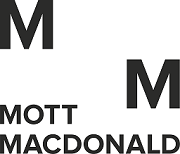

In [25]:
base64_data = "iVBORw0KGgoAAAANSUhEUgAAALQAAACaCAYAAAAAa2J0AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsQAAA7EAZUrDhsAAAAGYktHRAD/AP8A/6C9p5MAACiKSURBVHhe7Z0JuE5V98D3veZrJq7xmjKlyBzKVNeQoTI2Dygh0RdfkgyZSiUVUhq+6B9CisiUMREZIiWZJWSeSdz/+a2zzx3ee8473bdJ+/c857n33Wc+e+2119577bWjKlS4JkGFyMWLF9VVV12lVqz4SqdEnqpVq6hTp06pjBkz6pTAXLp0SY6fP3+Bio2N1amGfxPR+m9IpEuXTh04cECtXbtWp0SWAwcOqnXr1qvMmTPrFIMhOMIS6OjoaNGes2bN0imRpVu3LqpEieLq8uXLOsVgCI6wBBry5MmjJk+epM6cOaNTIsPx48fV999/L9o5ISFka8jwLydsgcZW3bp1qwhfJPnoo4/U4cOHpBaIiorSqQZDcIQt0JgDpUqVUj169NApaYdrzpgxQ2XLlk2nGAyhEbZAQ6ZMmdSWLT+okydP6ZS0M3fuXEugs+tfBkNopEmgIWvWGDVkyHP6V9ro0qWLKlSooLGdDWGTZoHOlCmz2rBhg7pw4TedEj6ffjpD5cyZU/8yGEInzQKdJUsWtWzZMrV69SqdEh6TJn1oNTQzmYagIU2kWaAxD/Lly6fGjn1Dp4SH06dtBNqQFtIs0JArVy41efJk/St0duzYoRYtWqSyZzeNQUPaCEqg0cL+GmrsK1gwVg0fPlynhMZnn32mzp49K33PXpiGoiEYAgo0goQZ8Pvvv4tTkhfZs+dQs2d/pn+FRr9+fVWRIkU8hZb+6d9/v2iE2hCQoDQ0XmyNGzdRWbNm9fSvSJ8+vdqzZ49asmSpTgmOJUuWWAUmWhyevDhy5Ijq3LmLOnr0qE4xGNwJKNBoZ8wB3DkzZEhnaUm9wwfMhTNnzqrFi7/QKcExduwYcUX10r4nT55UrVu3Urlz5zLOSoaABKWhEaTo6HTqgQceEj8Lt54IBDI2Nr8aNWqUTgnMzp07ZaTRn8/zb7/9pqpVqyH3NCaHIRBBCTTgLtq1azdLoI/olNRgNqDNFy4MTkszzI1QY674gvCyYeZ06NAh4l59hiuToAXaqe5btmwhZoAbCGDJkiXVU0/11in+mThxgsqfP9ZV86KRz507pypVqiS/aZQaDIEIWqAdoevR4wnxWfYCbXvkyFG1evUaneLOiRMn1MqVqzw967DJd+7cpUaPHqNTDIbABC3QDtWrV1MVKlQQ29YNW7OeVYsWLdQp7nTt2kUVKxYnPShunD9/XpUpU1oVKlRIpxgMgQlZoBnNq169ul9npBw5cqjp06eJ3e0G6WvWrFExMTE6JSUUCuYsDhw4SKcYDMERskDD8OEvqL1797r2dgAOS2vXrlPffvutTknJtGnT1OnTpz1HBrGXixYtqqpUqaxTDIbgCEugY2KyiJam0eYGDci4uDg1YsQLOiUl8+fPde3ZcECg8YsuW7acTjEYgiMsgYYhQwZ7amkakJgdn38+N1UPxr59+9SUKR/Jfje4HtcdOfIVnWIwBE/YAl2xYiVVsmQJV/8OhBItXbBgATVo0ACdasNM8dy5c3uaK5x3+fIldd11FXWKwRA8YQs0kYnatm0v3W9eZMyYQS1dutxqQF7QKUr17dvXEnT3aVaOdn7llVd1isEQGmELNDRp0kRlyJDBVTghc+YsasOG9Wrjxo3ym8YgkwG8QDvHxGRV8fHxOsVgCI00CXTt2rUtgc4ogugFAWPeeedt+X/mzJl+fZ7pzrv55oaqTJkyOsVgCI00CTS89tprMuPEyybGk+7NN9+SfuslSxZ7jgyi5SkY8fGNdIrBEDppFuhGjRqJ2eGlpRHUIkUKq/vuu0f+d9PQTvqpU6fVgw8+qFMNhtBJs0AjzF27dlWHDh3SKalhzuG6des8QxSg3Q8e/FU98UTkojAZ/p2kWaChQYP64tPs1Tgk3V9oXLQzBaJDh446xWAIj4gIdNOmzcSJyMvRKBB477Vv31bFxRXTKQZDeEREoKFVq1Z+3Ur9QT91kyZN9S+DIXwiJtB9+jwtdrC/bjk3aEwycti8eQudYjCET8QEGu6//z6ZoR0KzqwUuvcMhrQSUYFu1669OnbsmGeftC9o8127dqvx4+2BF4MhrURUoOPjb1G1atWS2SbBgHauXPl6T887gyFUIirQRA+tUqWa5/Ss5KDFcSXt3PlRnWIwpJ2ICjT07ft0UHY0bqelS5dWTZua3g1D5Ii4QNNjUa7cNSlcRt1Ai5cpU1ZmthgMkSLiAg3jxo1T27Zt99s4pM+6e/fH9C+DITL8IQJN+AEae15amhFFhL1u3Xo6xWCIDH+IQNNrceONN7nOZnEag/3799cpBkPk+EMEGvDAIy4djknJnZYYGcySJbNq3bqNTjEYIscfJtDlypWTJd8c88IBrd24cVMJcB4O/uxygyGa7jN/G5HziZPhb5qVF0OHDpfoogi1cz20dYsWzfURwcP9nVUEvDb2sxn+vUQzJ9Dflj59RlmL0F9gGC9atmypcufOI0Pc9vUyqGzZsqq2bdvpI4Inffp0MnDDNXyfMfnGs3r5ZRuufKIOHDgQMPfRjjT0sIlDhUEWtKdjKiQkXFYFChSU/0OB0GGE8U2XjoLl/5GZWR6q15/hyiDK0mZGnRmuGIwaM1xRGIE2XFEYgTZcURiBNlxRGIE2XFEYgTZcURiBNlxRGIE2XFGYgZV/Kbt27VLvvsts+6igHb447vjxE6pt2zaqTp0bdWrkGTx4sB5d1glBgA8PywQagf6XsmLFClkVGBeBUASaSRu4QezZs1enRpY5c+aoO+9s7zcWoi88F5EGatSoYQT638rq1avVfffdK05nofi9cOzGjZskuOYfERyod+9eauLEiX5XenCDkBhVqlQxNvS/HfRZKBuuwMWLF1M9e0Y+9DErOHzwwQcqT548rvcOZjMCbQgZzIENG75VZ8+e1SmRYfnyZero0aMqXbp0OiU0MD2MQBtCBoE7ePCAmjBhgk6JDN26dVMlS5YUTRsuRqANYYGWXr58uf6Vdnbv3iVLklBYjEAb/nQIKPThhx/6XYokFIYMGSKTpyHYXhc3jEAbwoJZTLGx+dTIkS/rlPChULCWZZYsWXRK+BiBNoQFZkHevFep//3vfZ0SPtu2bbMamRtUpkyZdEr4GIE2hIVjFjB5+f3335P/w6VHjx4S1iIttrODEWhD2DhCvXjxEvkbLmvWrFExMTH6V9owAm1IE9mzZ1fz589XO3fu0imhwcggC7NGQjuDEWiDX9DChJDw6nmgm+3kyVOWll6kU4IHIV66dKnf8BiMTAYKzZwcI9AGTxBiRu5uueUWiYniBkIZF1dUPfnkf3RK8MycOVPW2PEKYkRPCmvDlyhRIqhVIcAItMETBPrAgQOqX79+6tdff9WpqUFLX7hwXn333WadEhwLFy5Q0dHefc5oZxygbr75ZnXuXHDD7EagDX65fNnunouPj1dnzpzRqSlBSxMNa/Dg53RKcIwePcbTY4/CRCEiii33DdbENgJtCEiWLDGqefPm4qLpRaZMGS0N/Z30KQfD66+/pnLlyulpm1NImEzQokVLy4Z3N3fcMAJtCMjp06dU+/Z3qpiYLGLXupE+fQa1Z89utWnTRp3in/Hj37K0egERXDcYPXSWLPG4pStGoA0BYXpTzpw5VcWKFS0t7b4GpW12FFBDhw7VKd7Mnz9PekaYLOAm0KRh6iQFxQ++S88ItCFoRo16XeYies1wwRdj7dp16siRwzrFHaZZ0RWHueFmctCjUaFCBVWvXuhr8BiBNgQNM1UQNK+VgjFHGCR59tl+OiU1rH42b9480fheYKs3bdpE/woNI9CGkOjS5VHpfXDTrJgKTKCdP3+Bp228evXXauvWn1TGjBl0Skq47i+//KKeeqqPTgkNI9CGkGB1s/z580sfsS+OCUE32/vv/0+npqRXr96qVKmSYiO7wagkAznhYgTaEBKVKlVS1157nd/haEb+5s6dq38lQeiDnTu3W9o5o05JCYVhz549auzYcToldIxAG0Kmc+fO6tAhd7MDsI8/+eQTmcWdnFGjRsqMbi+wnW+44QaVL1/44RGMQBtCpnHjxjLj28tORtDxwhs5cqROUerw4cNq5cpVfp34uWaDBg39NhgDYQTaEBYvvzxS7d2711VLI+gEimE00GHjxm9l0IVVynxJXjAY6k4LRqANYdGoUWPRtm6NQ6Cvmv100cGYMWNlYq2bVqdQYJMXLRqnChUqpFPDwwi0ISzKly9vmQf1PR2WgMbhe++9K/9//PHHnvYzwr9t23ZLo7+uU8LHCLQhbOrXbyga18uWJnbHL7/sV8OGDVMFC8Z6anMijRYuXEhVq1ZNp4SPEWhD2HTp0sVqyJ2zTIaUdrADq/4eOLDfMjdGiwuqG5gbDNQ8/ngPzyH1UDACbUgTbdq0VseOHXdtHAJ9zl62MzBcTq9G7do36JS0YQTakCYGDx4qZoWXQAcCM4TJATfeWFenpA0j0IY0wSDI7bffpk6dCt4J34FCsG/fPtWr15M6Je0YgTakmXr16ostHSoI9OnTZ1SrVq11StoxAm1IMx07dpRGH/awl63sC8KMV12/fs/qlMhgBNqQZhjmvuaa8olO+8HgdPe1aNFMp0QGI9CGiPDaa6PVjh07g+56wxGpevXq1lZDp0QGI9CGiMDASPHicX7dSpPz228X1U033RR274gXRqANEWPYsOel18KfkGJmsB/302ee8Z6qFS5GoA0Ro2rVKqpYsWIyS9wLhJmwYqyR+EdgBNoQMcqUKauKFi0qvhleYGMzc6VPn746JbIYgTZEFOJyECTGy+ogaE2TJk3Uddddp1MiixFoQ0SpWrWa1eD73XMSLAMwNWpUF8elP4Ko7du3J9AhbpeoKOkcx+2PqsMfjMHv3LlT/ncaAZcvX7LOzRLwXCCqJdNydu3aIb4AxAiuWLGSTIPnfK/unyNHjlga4LD1QQjBGlwnPtDfz3OWKlVKfm/dulXuYT97sNeJkiAocXFxfmMa/xNwlkYmcqjXtyZ906bvROOGsgwyM1WeffZZyUdnoMX5yzSr5cu/lCUogqVnz8fVtGnTVa5cuXRKaugGrFq1qorKly9fAqFQHaGkO4VgIV9+uUKmq3tBUL7SpUurnDlz6BQlzt61atVSy5Z5r1+3Zs03aty4N9RXX61QW7b8KEt54ZFFAWEYtECB/KpmzRvUvffep9q0cUJBJTFw4AA1aNBzEujP+UjBQEEl6ODBgwclUAoFhwCDZGiw8I0IIDh9+nTVqlUrnfrPxBboe6z3T5+Y977wbcIRaGZuV6lSWcXGxsq1nZ4NuvSKFCmqFi9erI8MjuQC7ZbnXBuBlrW+CxUqKKXF2YiZQNcL6174Y9SoUZbwxUopdM4tXLiw3xm7gwYNVM2aNVVz534uD1ax4nXq6quvlnOLFy8uv3PnzqvWr18vAU3q1r1Jn5kEroY4i3NfNKWzOc/gbMn3O//nzWvPmCCj6Dd19ic/zvc6vsfkyZM7IsuP/R2IiooWLexvCwe+U9Omt0qMDec6fPOdO3eo4cOH66NCwY73kfy5vLaoSpUqJtAqTV5KqRZw6fvqq690Smo4/tprr7UEMyk0JC9QtWplS4N9olOSuPPO9jK1HQF27kXBoYsHf1m0OyWYOWVobASesFFM4/nmm7WJGqJ//2fV4MFDrCqfRWYYPpVkEUaO5Tz+EoONa3MrjkFD582bV/388z65D2ZV5syZtIa2h2Fz5MgpxzhgXvz888/Wh3K+DUFUzoq2aN36n62hly9fKvMCRQiS5X1y2MfqrpiEBQsW0KnBMWHC++rBBx/U+RQlPR/kK0EaQ6Vjxw7q3XffU9myZZV88oXnd0IguAo0L0JV43YysILof/7zRKpqyEughw0bKiuFIswIFgWGRWbeeOMNsXswOy5csIWne/duItyFChWWc1kS4frrr1ezZ8+R35s3fydxiLHVHYFGaz722GMigDQ2du/erd577z2ZYewINY0UNCstbN4LocyQIZ28N9dgFaZly5bKu3GcLeA51MiRr+jQV9w9ynr2MxJE0Hm+fyoMbCxatFgLtE5MRZQ6ceKEZf7dKxNeQ4HvPn36x6IM+MaYtXTrMdwdKmvWrFY//bTNKhDeDclLly6LPKYQaISNhh2xfvFvbd68pRozZow+JYmGDRtKLGAynpKBtgM3gV65cqW6447bE4UfYUYLY6N7gZ1MTAc66XkuCtfkyZNV+/bt9RGpqVTpeutZzsizcPz58xfERg4FJnTSmMFWw6bPnj2H2JqGfw6JRhIZSNWfNWt2+T8mJqtaunRxKi39zTdrrNKyVUosAkzPBBFykmv45GBmcD1bEybIOfPmzdd73Rk4cJCsq0FjhHPw5Orevbve60XKCZjnz4fun2tr86T38H13w9+fFFb/sWPH1NNPPy22LXbo0aPH1EcffaT32iCMmARUVXSh9ev3jHS/eQn0O++MT9TOmALjxo0LqsvruecGWzVATGJhoOpascJbqxsMkCjQCA32UsOGDURY0U5sS5akXH9uxIjnpcFIg+3ee++37NCMYqq4geAfOXIssZGHnXzHHcE1phhJsswhsYsB2zictfAM/y5SaGiEjsYT1Tv9tWjW8ePHi2DCqlVfWzbwOUt7p5PquU6dWomC7wa2LIY8++n7ZYQoFGiooaGBAkfDwGDwRyqBZqMPEc1LLwJdWW+++abs79WrpypRoqQIc/bs2dQ999wrjTwvjh8/KqYLoMVz5crtaZq4kTNn0sgQ53nVBAaDQwqBBjRp7dq1pYeBUUMWgsHuhUOHjliCnl6EuFatOpKGcHtB6CdnP/29x44dlf+DBbMmOZhCBoM/UkmIYz7QKX7ixHERIrq/br/9dhmQQDB3796j3nrrLTnOHzVq1JRCAXTxEU6VftxgoPsQgbYHPniuy9KjYjD4w1PlEdT64MFDItDYsYRDZTIk2hlH7mA72hk+pmFHQcH/wmupAl82bdqk1q1bm3gflhNr3LiR/G8weOG3Dscbi645hJoGGtBY7N37v/J/MDzyyMOJ60QzoDJw4HPSmxKIDh06yD2xnTFbsMUZajcY/OFXoJ966r8y9OzAiCLD13Xq3KhTAoPXHIM1NOgQTsb269a9Ua1du1YfkRJ6Ue68805xTWUlfgoTqyYxlm8wBMKvQMfFFVM1a9aUhiIg0LZHWvB+DCVKlFB9+vRWP/30kxborJaGPqlatbpDtW3bRs2ZM1t8kxli7t27l7ruumvVihVJ/rIEI2FZ3qZNm8pvg8EffgUaX4Z69RqIvwbCuG/fL+rVV5OWGQiWbt26q06dOokHHPY4tjjaFy2NNi5fvpyqX7+umjTpQ2mAOmtsMLJ40012usEQDNE01mynJHtzejkc8KqjIUjDDiFE4yaH4+mBQFDta7gPsowd+4Z688231A8/bFGHDx+SY3Ekwnf2mmuuUaVKXS39ztyeAsSgDObKjBkz9BX8c+lS0nuA73sEA+fyHs67/P67e4Buw98Xy0RNco52c89DWzILZd++/eqVV17WqUnY52WRv3SxMQPCi7vvvlsE7a677pHjERwcm/AhoYvOHua+rEqXLiP+IWPHjrVPDAKenftTk9BFyN9Q4Xwan9HR9nWYBGD4ZxF1/PixRGWGgDEY4iYM2LJuC7rQA4FA4q9B3zECjR9xMKxbt058oOn1oHsOu5nQUPZ8wdDgGYCCgu9t/vyx8jsUaCtQG3EN4Hskd/g3/P2JsqQ59LrZYPib4rdRaDD80zACbbiiMAJtuKIwAm24ojACbbiiMAJtuKIwAm24ojACbbiiiBo6dGjCpUtJ06gIhVqiRDHVoUNHneIOgRVfe22UeOA5I2sMXRctGqceeeQR+e2P559/XmbA2GG2iOp+Qt199z2qcuXK9gEhgLfemDGvq40bv1NRUXY0JXxKGLL/7397qzx53Ef7GG5/5plnJMyV7/gSP3m23LnzqAoVrlH16zfQe8JjypTJ6rPPPhOHKyYZ8874suD8hZtuIGbNmqlWrFipsmWLUefP/6auvrqkevDBh/Red+bPn68WLlwgI7f4x1SuXMU1AKYvgwc/J74sTr5evPi7uC2UK1dOfnuxa9dO9c4778h8VL4dgS1feuklvdc/7777rtqxY4c4p/lC3hDSAk/POnXqyF9PihePS7AyNKFQoYKyxcbmT7jqqrwJ69evZxDRk4ULFyIBCYULF0o8N2fO7Anx8TfrI7zZvPk7uU/y++bLd1VCXFxRfURwzJkz27pnzoQoS4o5t3TpqxPKlCktG/8XKVJYnjE+Pj7BEiR9VhJ79uyW/RznPIfvxnNmy5ZVjrMEO2Hx4sX67MBYBTbBylA5N1eunAnFixdLfD62UqVKWt8gVvY3b948YcuWLfrM1PTs+XhC5syZ5Jmc9/r889l6rzsDBvRPsAqP5FHWrDEJDz/cSe/xZu/evXLtokWLJH4D7tu5c2d9hDfLli1NyJEjm+Qr9+Q6wdK8+a0iP849fbcCBWIT8ubNI9dksxSRlX979NlJRKOBiJjkbPny5bM07QW1dOlS6zxv+vTpI5FKCZvFefiAcC1cQwOxZMkS0QD4STj3JfQqGpuYd4HAx6JTp46qZcuWEgH12msryH1xLLIdpGwnIxyriGj63XebJIbe11+v0lewQVPituI8Axvvk3zjGZ3IqPh63HprU0tb19dX8AZXWasgqX79+snz4afCDBzn+djwX2HBSnzAid9Wv349S6Mu1FdICZGseD6+M+9FrYE34vbtO/QRqcG/hnfgHLZgAvx07drFqqGLi1Z3vgkTppcuXSIOY/4gdoojT9yP4IrBki1bdn0/+3zffOB6TNjmW/Huo0e/purWratmzpylr2Aj7qPJ4Tdhcal2vCCc14YN68WrzYHz7GulvJ4vFy/+JnHqEECOd+Lq8T8f5KWXRugjvalWrapUwVSBnINDEQ5OCBzRQale2RwPPrvg5JKIoYQxc+Bx5ZHl/wRxtLKvcUY2rstvrsOkBN63ZMmSVtW4XZUtW1Y8Bd3Yv3+/xP8jfKxVU8j7cY0zZ04nXt95Rqa4UUBRJGQcBeaLL77QV0qN/Y1tEJhOnTroX95wjn2e/7zhG27YsCExViHfw8mX7du3q/XrN0i6P5znS/6coWG7AZNvfH8nH9iQOyc8XFxcMTFPiJv45pt2VAJwbRQSrPHIkaNWxrkHdhk4cIB43oXz0Ni7RHBHW/DBCGaDpxyZzofEA49M9mLQoEEy+yU21g7vivBQql988SVZ+BEbFS2PP3XXrt3UgQP75TiE8eDBXz3tez4gwbgXLlxk2apfSTDJpUuXqU8++VQ9/XRfVb58WfE4xK5EQ7JWCMLnxj333GVlwBk5DjZv3iy1yYcfTtbPuEee8euvv5b5mYReo2CjtQkif8stt8jzBMIOJrnGukZkFn+fMGFCou1M3pBHFDbymVqKwON/BqySxVothFFGVsiLBQsWSuDQhx9+ROaoIujUwmjrrl27JloUKQSal6Da56UwJx59tIvekwQlhYygukQIuXAojBr1aqKfMRnJWs+sFEAGItDMYiHD3fjxxy0ya5wqkGdE69WoUUPCwjLzJTlMRujbt69atWq1ZXJsthqMm1S3bt3UxIkfuBZE0tKli5baic0Jdk5IMj7Y55/Pk4/JygVAQxMzYerUlLH/0K5kBBoXaOgQp2/MmLES7yQ5+fLlV0888YT1TBOlEPNOfFPLfpVJwoHgmUuWLCETJ2bO/FSnhgfXwqxASHgGlgzh+9FgprCR38zzdCY8/5FwP2pVNhqA5AdzWZs1a259y+fUxx/PsL4VNepF+WZMOqFxjwwlCjTCjI1CWH+qRewvtN22bT/pI2xYTmDjxo0ifPgyIyTMBOcjBMMHH3wgNhL3I9OvvrqU1cp/WlmNEbkGgtSjx2P66JRMmjRFtDkaxNEk06ZNszRVNn1EajANpk6dIgJDYeL6Xs/KNflIXtAzc/vtt4ktySwdZtn4anwi1PNeCAiFndALfGx/tGjRUmxtNBOgGdevX2cV4B/lty88v3Ms9ylYsKB6/PHH0yRsW7f+aBWKmaIIuCYmVuvWbayaqYKYRqTxXsT5/jNAPrxgBdpZs2ZZMmMv8kntu2rVSkuTL08SaISDmM+s7klDA7vp8OEjqeI4Y7syc5sbYi40bBgvGReMQI8ePdo6J698HEoTYcWYnXLDDTWt6jmXXJPM/PJL95UDvvhioZRaQDvTKKKxFIg2bdpJoyIS9O7dWwoz7wA09JiVDtQsx48fEy0HvCNdkcHQo0dP6QrlO3I+BXzLlh/03iTYz7vfd999onDIN/KKb8dyH+Eydeo0aQhyPWb6P/zww5KOVnSECyVHfJZwQhVHGkJa1Kp1g1gMgCyuWrUqpclBkHBs45o1a8iBNKSIkITmcqB6o6pE4z3wwANW5npHH/VlwYL5iZlNqWfWN2BC3HxzQzH6AZNk4MCB8r8D1dCXX34pwkSm7t9/QOysP5vKlauqMmXKiLDyHNi9K1Ysk330wyJkCBj7CBqPlgsW1pRxvgGzdrZt2y7/+0JjlFAS1Bgs0MO9qPVQRL16hWdPE+gdTU9eMibgmDzNmt0qckEB5tsTHzxQfO8/iwEDBoqVwPtTsxCYyKdRaK9WdP/9D0j1hfYhAv/evbZN++qro0TD0lDg5erUqW3Z3IEbL0DDCIHkmmgB1u1IbqNjX/LR2Dhm3rx5eo+NoxERID66HQH1r5nE6oQHBp6F2fCAoCGQfEP2syhPKNC1iLkHLKfhLJuXHK7NRvujW7fHVLVq1URjcz9sTZbiCLTgky9Tp061Gtn55Rrcn1XIKlasqPcq1b37Y9K7AATcnD59qvz/V0NXrxNqDkWJkkvxxckjNCExMFhDhKqGGBzOykUEe0G1s54F3W4NGtwcdPUzZcokyQiEGfuvefPmeo8NPRJoPUDD0eWFRneDD49Q2aOMfz4IsfUqgiO8QLrzP38pfKFA75Jzvn1d95qPezuz62fM+ET+d+6NSda8eTPZx3cMhilTpiR2wTIGUb78NaJUHB56qIMl0HYfNKbbxIn/J///1TjfKjmpVIht25ZQ5cqVlR4Pup5YsIfGIFUomXTw4H6rEdJDjne7qBuDBw+VQRBAu2CL+lKvXl3RcAg9GTR/ftIgAxkMpPMMRFhybLs/G/u+9vPwXASABxqnCALfhHegqg4F+vap+YBvjxtBIFAsxPCmB4hnoTcCQW7Xrq1osEB8++0Gy4xYLQLN+fTjDxjQX++1ocuuTZvWUgPxbvnz51MvvPCC3vvXwcJHrGQG5Am9ZZ514qOPPppYzeTIkV1sM9Q6GXXs2Img/DUc6Oazbd9oKTD0pOBXgHBSI7DBsGEvSL8y8HAvv/yi/A9oL0bcyGg+Kgt+fvpp6uXj/mhYhYuuOISG52AjUA4UKFBI7FBMMt4NZcBARbDQ7+2M5tHQpvsuGG699VbLLOhhmYY/y28GaOjPx68CjcozekFE2GPH7CivDHrRC0QbiXxKnjeMejrfnmt+5LNUyV8BYS6QE56Jmf507XkKdOPGTRJfgJJLI5HSj21NF1Eo0NcaF2cvk4sg0KCkkPARMR3YuEe5cmUs4SgvwsBvDP0JE+yYdtZPK+OaJYYroPH62GOBFhKyIcxYpPpPR4wYISNqPDvPeO7cBXXjjfYCoQg2AuE0GDNlyqD69+8n+wIxfvxbcjznoW2oJatUqar3BoaFUCtVsofnAQVCd2ogs6N///5SCMkblMa5c2f1s2dKkTdPPfWUdNsBSg3tOHv2bPn9V0BjeNKkydIzA5hEt912u7dAw/PPv5DYiiQDeWlKbIsWKe1ffzAySJxpznegesM3wncjghKZyf24Fx/69deTgs00atRIagn28VEJLsOijP6gcBCfr1GjeDVyZOpAOb4kf05fOJ9+b6cqx1/jySefkP8daH8wisg7ZM2aTX311Uo1efIkvdcdlAXtFKcLkm981VX5pHCHwrRpH0vPCN8GnB4lL/bs2Su1MELrkDFjZte8YYCDbwm8GwUnkL9PWnDewQ26RlkLqEyZ0iILKF7WcMcVwq9AM7SL8DkvguYpV668xJsLlgULFliFYl+ioPAh0NBoTN+Nj8s+qmwgQwgb5vSFs9Qbw8IcxwtTpbNsHL0tDHbwfA4IBe6a9MrQHqCbkK7AsmXLyP++WHlkPWN66THAjkcLs/FcjDJyD7oJ8eXgIzK0jTb2DS3cs+cTlnbMYl3D7lNmsOquu+62BHZoYu3igE26du06sb3RpI42pXeD9woVNCjBL726+3zp3PkRGRF28peCdeTI4VT5wsY3p3+adwI6Bxi1dXoZ3HCiaDnf0m1zA1khL9k4hk4E7k3f/Pjxb4urA7LB9+J5qIn47jyT3yJctmw5VbduPfFSo/GBMNaufYNUR8Eybhx2jj1yRkmiz5kMdjrEk8O3QlvQPcjxPCzHzZkzy6rW7SUwGLrmGnxgXgDTg0YmGYPPMj4X1qliuy5btkwaNHwgPgC9M1RTTos+Ofjw/vLLPlnc0ylQVpNX7kMtgwng+K/gP37gwK+yJrmbFsT/4PrrK1n7bI86NNyIES+qt99+RzVo0EDsPt6L7rW1a79JoYlxAho8eHDYA0Gsj3PbbS1lCTynOnaD99q9e1eidqZw0QXYuHFj18YsPUp8VyLE0g/Pb5TPihXLrXdqqI9Kgu9EvlOrYsZYuWvv0DAimytXHlnslEKfHJ57yJCh6sUXX5Q8Qy6QvR9++MH6P1o87hyzlNHUTp0eThwIiqpc+foESgIPgAZhpSt8GBzwM3jmmb7S0MDhh+OSw3rgDIrgVMNHYRX+6dPtAIv0z9LtxwPA999/bwnZl1ahqCW/vWjRooX18JstwYuRQsALIiSOIKIx6JrCjuK5yBReECFx7H6OpceBl0Yjo7WWL19uFYyk2NYIMFqWUSfO5zy7EeS8o21qOdfn2rwjWhyBpmHqBQ1hzI8cObKJ6cF1uDaNPces4vmcXg2enVqmR48e4vvhC3lAHzOFGDMQc9Bfw5zjWKzfEVg0XevWrdUrr4yS32+8MTbFYArfaNq06dJg9wd5x/fn+9KIRAtv3vy97GP4GZ8a2j4OfDPe1Re+BX3a2OEoirvuulPOx42UfOAboVicc/nLu1AzI69OTU9ffPIF8aOxb8kg7BL+T9JONgyxsg/hwf/UFx6MEm1f47iV4fZIF3Ts+JClaXJLQUEjIJgMVwaCIfLt23dKJtB6pVrGh9oBDYeXWbt27URb4n2HoKEtEXBGzfif56EQkbnr1q1PIcxALD7Kp/Ps3A/BokuQjUwmnV4NzACujTZgeQx/wgzY7XzwChWuFUcfqksyl14MtC/mEhlHVYpWLlSoiPQHuwkzOM/ibFzLH/Ry8Nxcn+PJA94NEBY0I4LMPp4TQQokzPDII51lRJLzMKtoRzjB67mu/Xx28E02ntv+pkkbaWyO8gEKunMOG2afcy5/+U0PGPnJfWhvLVq0JIUwQ5RVShMchxwecMCAAYn+Eg4TJ06Q6Tx9+jxtZVAFnWqD99nw4cOkpHNj/DNYSJ6PRVefrYFsrzwKBFoiGLp0eVRKMFUbAkSt0bNnT703iZ9/3iujkJ9++qkIBi6e3JvnsWofFR/fWBznM2ZMbSZRgLt3f1x6YNzCADOwgYsmJgFmDo7v2G+hQlWJJxujrpgvFD7sPxoyOE8xPM4C/f4aQtOnT7Nqt+Wi/RDOdu3ay3v5Y9KkSWIuUkOcPXtaVa9eU6ZSISRod96J2ujkyVOyKBRtlEAwwotzPXKI1iRfmRaFcsFP/PXXR1va285zf6CIeC7yFEVHjYEsMULqC/lJD1CRInFiCSALtGVSo9T/A68G23VyqryLAAAAAElFTkSuQmCC"
Image(b64decode(base64_data))

<br />

# Instrumentation and Monitoring Data Interpretation Tool – Embankment Settlement Monitoring

This data interpretation tool was prepared as part of the Digital Committee PMO’s Optimisation Programme by Fabien Blanchais and Kalyan Kamepalli. The tool is a practice approved tool of the Geotechnics Practice.

The tool is producing the following plots:
- Settlement vs. Time in relation to the height of the embankment 
- Piezo level vs. Time in relation to the height of the embankment
- Crest and toe movement vs. Time in relation to the height of the embankment
- Excess Pore Pressure vs. Time in relation to the height of the embankment
- Factor of Safety vs. Time in relation to the height of the embankment
- Embankment stability control chart based on Watika and Matsuo (1994)
- Ultimate settlement based on Asaoka (1978)
- Ultimate settlement based on Guo and Chu (1977)
    
The following references were used:
- Duncan, N. et al. (1999). The Observational Method in Ground Engineering: Principles and Applications, CIRIA Report 185 
- Asaoka, A. (1978). Observational Procedure of Settlement Prediction. Soils and Foundations, 18(4),pp87-101
- Matuso, M & Kawamura, K.(1977). Diagram for construction control of embankment on soft ground. Soild and Foundations, 17(3), pp37-52

For more information about the tool and utilisation, see https://github.com/mottmacdonaldglobal/GeoTechSettlement_Dashboard
<br />

In [29]:
home = str(Path.home())
warnings.filterwarnings("ignore")

print("\033[1mSelect files format:\n\033[0m")
        
format_data.add_class("left-spacing-class")
display(format_data)
upload_comments.add_class("left-spacing-class")
hbox1 = HBox([upload_settlement, upload_load, upload_piezo,upload_crest, upload_toe])
hbox1.add_class("left-spacing-class")
display(HTML("<style>.left-spacing-class {margin-left: 95px;}</style>"))

print("\n")
print("\033[1mImport files with upload buttons:\n\033[0m")
print("                   Annotation")
display(upload_comments)
print("                   Settlement          Construction            Piezo                Crest                 Toe")
display(hbox1)
button_code[0].add_class("left-spacing-class")
display(button_code[0],button_code[1])

    
###############ON_CLICK################

button_code[0].on_click(on_button_clicked_code)
button_code_plots[0].on_click(on_button_clicked_plots_code)
button_settlement[0].on_click(show_settlement_plot)
button_piezo[0].on_click(show_piezo_plot)
button_pair_s_and_t[0].on_click(show_pair_s_and_t_plot)
button_porewater_pressure[0].on_click(on_button_clicked_porewater_pressure)
button_asaoka[0].on_click(on_button_clicked_asaoka)
button_guo[0].on_click(on_button_clicked_guo)

Select files format:



ToggleButtons(_dom_classes=('left-spacing-class',), button_style='info', options=('.csv', '.xlsx'), value='.cs…



Import files with upload buttons:

                   Annotation


FileUpload(value={}, description='Upload', multiple=True, _dom_classes=('left-spacing-class',))

                   Settlement          Construction            Piezo                Crest                 Toe


Button(button_style='success', description='Upload files', style=ButtonStyle(), _dom_classes=('left-spacing-cl…

Output()